![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from math import sqrt



# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)
data=data.astype(int)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [2]:
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.048213,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Función de error cuadrático medio (MSE)
def mse(y):
    return np.mean((y - y.mean()) ** 2)

# Función de impureza utilizando MSE
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    return mse_impurity_

# Función para encontrar la mejor división
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    # Para todas las variables
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = mse_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    return best_split

# Función para hacer crecer el árbol de regresión
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

# Función para realizar predicciones con el árbol entrenado
def tree_predict(X, tree):
    predicted = np.zeros(X.shape[0])
    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
    return predicted.astype(int)

In [ ]:
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)
prediction = tree_predict(X_test, tree)

rmse = np.sqrt(mean_squared_error(y_test, prediction))
mae = mean_absolute_error(y_test, prediction)

print("RMSE:", rmse, "MAE:", mae)

RMSE: 1643.317917244335 MAE: 1223.661662817552


Para una interpretación adecuada de este valor, es necesario considerar la media y la desviación estándar, ya que proporcionan un contexto relevante para el caso en cuestión.

En el presente modelo, la media de la variable Y se sitúa en torno a los 14538, con una desviación estándar promedio de 3922. Tanto el RMSE como el MAE exhiben valores inferiores a esta última cifra. Aunque aún se percibe un nivel de discrepancia relativamente elevado en relación con el contexto de predicción de valores de vehículos, los resultados ofrecidos son satisfactorios desde una perspectiva predictiva.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
#Muestreo
np.random.seed(420)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


treereg = DecisionTreeRegressor(max_depth=None, random_state=420)
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for i, sample in enumerate(samples):
    X_train_bm = X_train.iloc[sample,:]
    y_train_bm = y_train.iloc[samples[0]].values
    treereg.fit(X_train_bm, y_train_bm)
    y_pred.iloc[:,i] = treereg.predict(X_test)

RMSE=np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
mae = mean_absolute_error(y_test, y_pred.mean(axis=1))

print("RMSE:", RMSE, "MAE:", mae)

RMSE: 3753.5533410364383 MAE: 2981.8160510801267


Considerando las observaciones del primer punto, se deduce que el rendimiento del modelo de bagging manual es inferior al del primer modelo, pero aún así es considerablemente mejor que el modelo implementado con las bibliotecas de sklearn.

Los valores de RMSE (3753) y MAE (2981), que superan la desviación estándar del caso, sugieren que el modelo no es adecuado para aplicaciones predictivas y requiere ajustes en sus hiperparámetros, sin embargo dan una idea del comportamiento del modelo bajo distintos metodos predictivos.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
# Configuración del modelo de Bagging
n_features = X_train.shape[1]
bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=int(np.log(n_features)),
    random_state=42
)

# Entrenamiento del modelo de Bagging
bagging_model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = bagging_model.predict(X_test)

mse_bagging = mean_squared_error(y_test, y_pred)
mae_bagging = mean_absolute_error(y_test, y_pred)
rmse_bagging = sqrt(mse_bagging)

print(f'Mean Squared Error: {mse_bagging}')
print(f'Mean Absolute Error: {mae_bagging}')
print(f'Root Mean Squared Error: {rmse_bagging}')

Mean Squared Error: 7663764.018995856
Mean Absolute Error: 2160.762049592191
Root Mean Squared Error: 2768.3504147769763


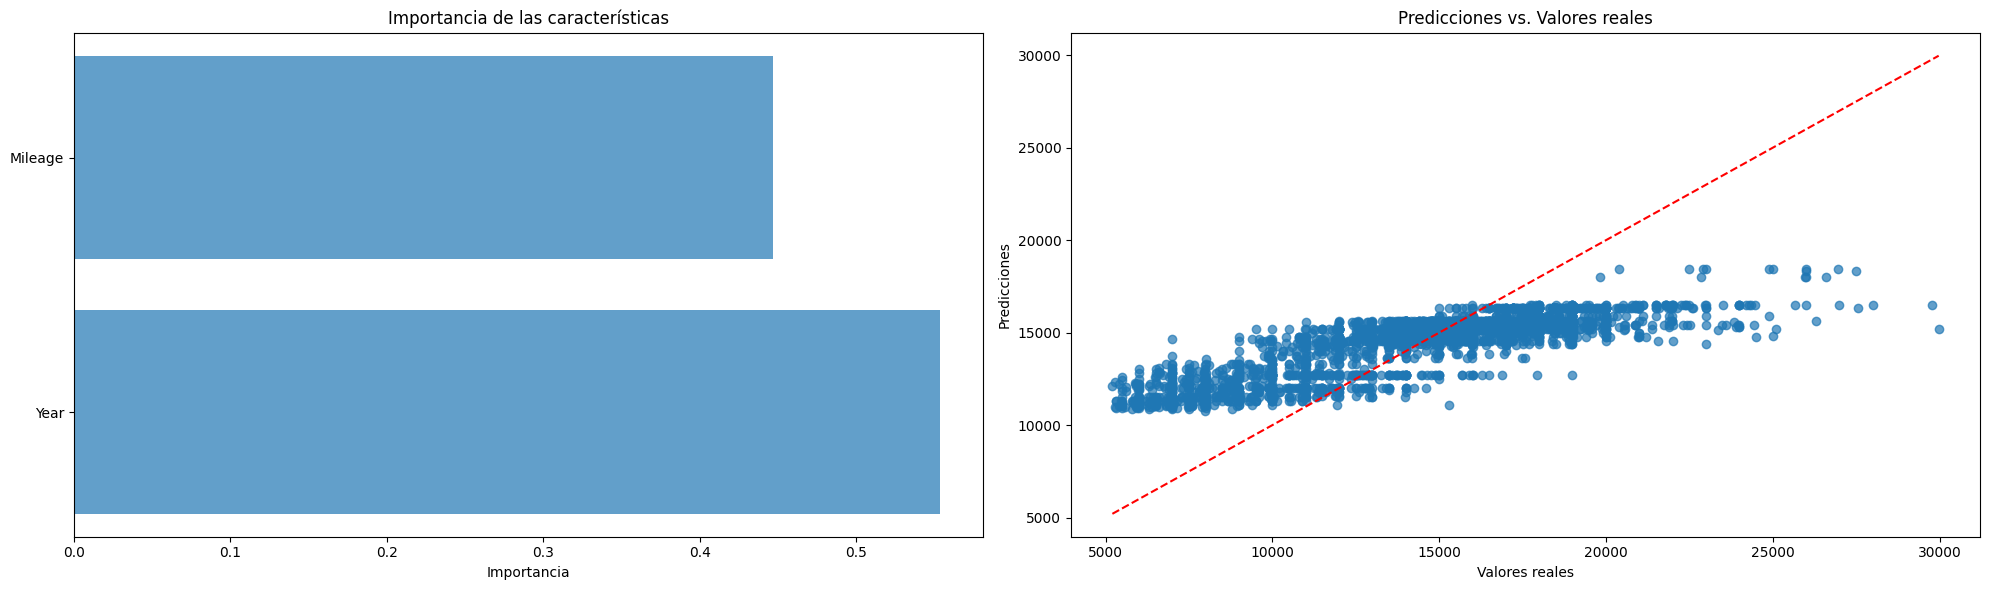

In [ ]:
def plot_combined_bagging(model, feature_names, X_train, y_train, X_test, y_test):
    # Obtener la importancia de las características de cada árbol y calcular la media
    feature_importances = np.mean([
        tree.feature_importances_ for tree in model.estimators_
    ], axis=0)
    sorted_idx = np.argsort(feature_importances)[::-1]

    predictions = model.predict(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Gráfico de la importancia de las características
    axes[0].barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', alpha=0.7)
    axes[0].set_yticks(range(len(sorted_idx)))
    axes[0].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[0].set_xlabel('Importancia')
    axes[0].set_title('Importancia de las características')

    # Gráfico de dispersión de predicciones vs valores reales
    axes[1].scatter(y_test, predictions, alpha=0.7)
    axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    axes[1].set_xlabel('Valores reales')
    axes[1].set_ylabel('Predicciones')
    axes[1].set_title('Predicciones vs. Valores reales')

    plt.tight_layout()
    plt.show()

# Suponiendo que rf_regressor es tu modelo de Bagging, y que X_train.columns es accesible como los nombres de las características
plot_combined_bagging(bagging_model, X_train.columns, X_train, y_train, X_test, y_test)

* Un MSE de 7,663,764.02, lo que sugiere que el modelo, en promedio, se equivoca por una cantidad considerable en términos del cuadrado de la diferencia entre los valores predichos y los reales. Un MSE alto podría deberse a varias razones, como la alta variabilidad de los precios de los automóviles en el conjunto de datos o una posible subajuste (underfitting) del modelo a los datos de entrenamiento. Esto último significa que el modelo podría ser demasiado simple para capturar patrones subyacentes complejos en los datos.

* Un MAE de 2,160.76 indica que, en promedio, el modelo se equivoca por aproximadamente $2,160.76 al predecir el precio de un automóvil. Comparado con el MSE, el MAE es menos sensible a los outliers porque no eleva los errores al cuadrado. Por lo tanto, puede ofrecer una mejor representación de los errores típicos si el conjunto de datos contiene outliers significativos.

* Un RMSE de 2,768.35 sugiere que típicamente, las predicciones del modelo se desvían en $2,768.35 del precio real. Dado que el RMSE penaliza más los errores más grandes (por la cuadratura del error antes de hacer la media), esta métrica sugiere que puede haber errores de predicción significativos que necesitan ser abordados.

*  La elección de usar max_features=int(np.log(n_features)) implica que cada árbol utiliza un subconjunto de características basado en el logaritmo del número total de características. Esta técnica puede ayudar a mejorar la generalización del modelo al reducir la varianza de las predicciones, pero también puede ser insuficiente para capturar toda la información necesaria para realizar predicciones precisas.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
# Crear el modelo de Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred_rf = rf_regressor.predict(X_test)

# Estimación del desempeño del modelo
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("RMSE:", rmse_rf, "\nMSE:", mse_rf, "\nMAE:", mae_rf)

RMSE: 1765.4118259983413 
MSE: 3116678.915374798 
MAE: 1314.4207078056425


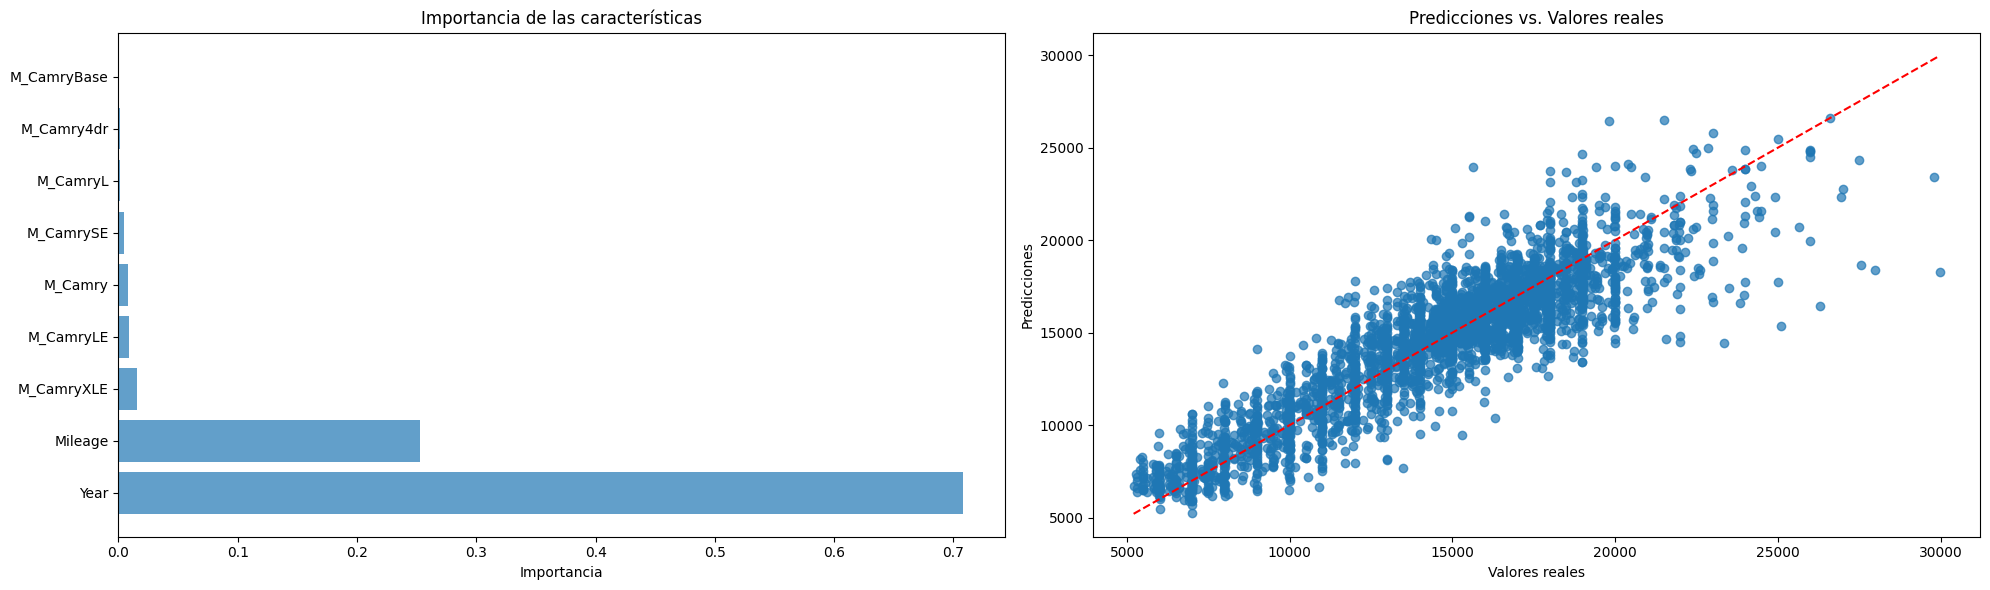

In [ ]:
def plot_combined(model, feature_names, X_train, y_train, X_test, y_test):
  feature_importance = model.feature_importances_
  sorted_idx = np.argsort(feature_importance)[::-1]

  predictions = model.predict(X_test)

  fig, axes = plt.subplots(1, 2, figsize=(20, 6))

  axes[0].barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', alpha=0.7)
  axes[0].set_yticks(range(len(sorted_idx)))
  axes[0].set_yticklabels([feature_names[i] for i in sorted_idx])
  axes[0].set_xlabel('Importancia')
  axes[0].set_title('Importancia de las características')

  axes[1].scatter(y_test, predictions, alpha=0.7)
  axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
  axes[1].set_xlabel('Valores reales')
  axes[1].set_ylabel('Predicciones')
  axes[1].set_title('Predicciones vs. Valores reales')

  plt.tight_layout()
  plt.show()

plot_combined(rf_regressor, X_train.columns, X_train, y_train, X_test, y_test)

**Análisis Random Forest**

Respecto al desempeño del modelo se obtiene que:

* El MAE de 1314.42 indica que, en promedio, las predicciones del modelo tienen un error absoluto de alrededor de 1314 dolares con respecto al precio real de los automóviles.

* El MSE (Mean Squares Error) es de 3116678.92, y nos da una idea de la magnitud total del error del modelo, sin embargo, se utiliza el RMSE para interpretar.

* El RMSE (Root Mean Squared Error) obtenido es de 1765.41, lo que indica que, en promedio, las predicciones del modelo tienen un error alrededor de $1765 con respecto al precio real de los automóviles. Cabe resaltar que esta métrica magnifica la importancia de los errores más grandes en comparación con los errores más pequeños.

Estos valores nos indican que, aunque el modelo puede hacer predicciones precisas en promedio (como se refleja en el MAE), todavía hay una cantidad significativa de variabilidad en las predicciones, como se muestra por el RMSE relativamente alto. Esta variailidad puede ser causada por una serie de factores, como la complejidad del modelo, la calidad de los datos, la selección de características, entre otros. Esto es soportado por la gráfica de valores reales vs valores predichos, donde se nota que al modelo le cuesta predecir precios altos de automoviles.

Adicionalmente, el modelo le otorga más importancia a la variable `year`, luego a `Mileage`, y menos importancia a las variables de `M_Camry`.


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5
# En este caso, log2 es igual a sqrt ya que se obtiene 3 caracteriscias para ambos casos y
# por lo tanto se usa solo uno de ellos
param_grid = {
    'n_estimators': [50, 100, 200, 300, 350, 400],
    'max_depth': [None, 10, 20],
    'max_features': ["log2", None, 6, 8]
}

# Crear el modelo de Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Crear el objeto GridSearchCV y evaluar con el RMSE
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Realizar la búsqueda de cuadrícula
grid_search.fit(X_train, y_train)

# Mejor combinación de parámetros
best_params = grid_search.best_params_
print("Mejor combinación de parámetros:", best_params)

Mejor combinación de parámetros: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 350}


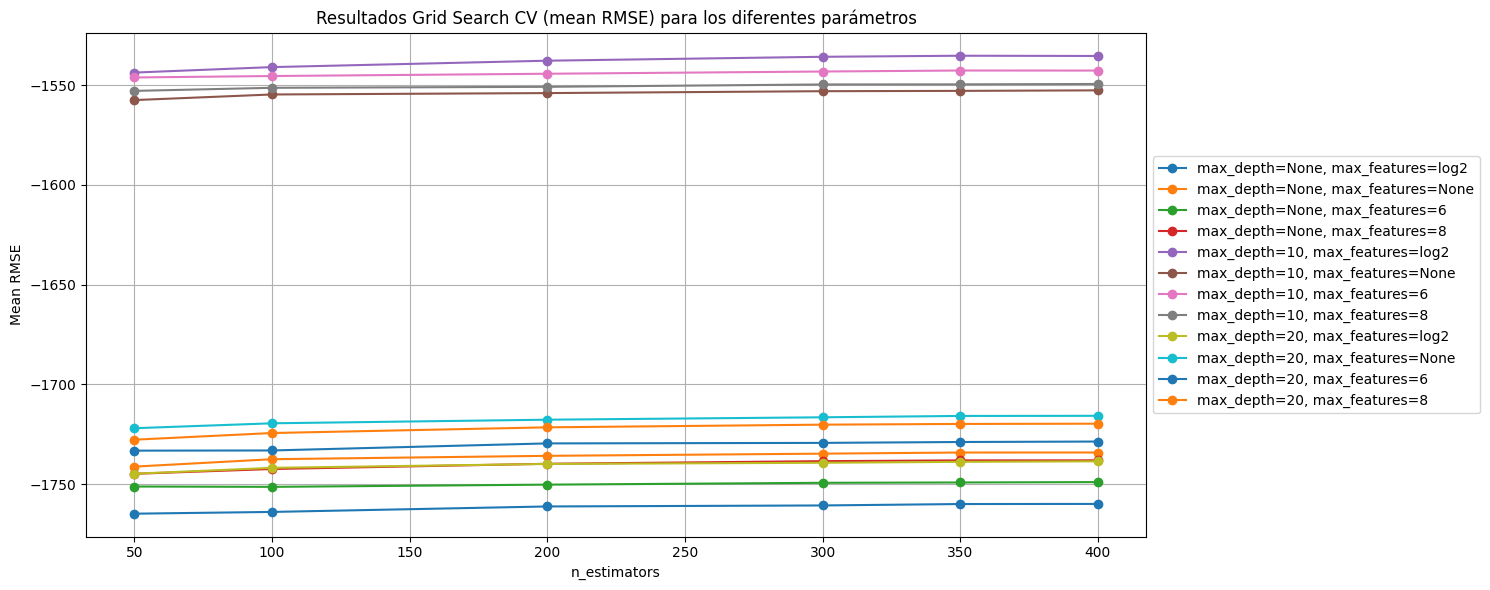

In [ ]:
# Extraer los resultados de la búsqueda de cuadrícula
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# Extraer los nombres de los parámetros que estamos ajustando
param_names = list(param_grid.keys())

# Valores únicos de los otros parámetros
unique_max_depth = param_grid['max_depth']
unique_max_features = param_grid['max_features']

# Crear una figura para la gráfica
plt.figure(figsize=(15, 6))

# Iterar sobre cada valor de los otros parámetros
for i, max_depth in enumerate(unique_max_depth):
    for j, max_features in enumerate(unique_max_features):
        # Filtrar los resultados para el valor específico de max_depth y max_features
        mask = (results['param_max_depth'] == max_depth) & (results['param_max_features'] == max_features)
        mean_scores_masked = np.array(mean_scores)[mask]
        n_estimators_values = [param['n_estimators'] for param in params if param['max_depth'] == max_depth and param['max_features'] == max_features]
        plt.plot(n_estimators_values, mean_scores_masked, marker='o', label=f"max_depth={max_depth}, max_features={max_features}")

plt.title("Resultados Grid Search CV (mean RMSE) para los diferentes parámetros")
plt.xlabel("n_estimators")
plt.ylabel("Mean RMSE")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Mejor modelo obtenido
best_rf_regressor = grid_search.best_estimator_

# Predicciones con el mejor modelo
y_pred_rf_best = best_rf_regressor.predict(X_test)

# Estimación del desempeño del modelo
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)

print("RMSE:", rmse_rf_best, "\nMSE:", mse_rf_best, "\nMAE:", mae_rf_best)

RMSE: 1564.778629174072 
MSE: 2448532.1583198877 
MAE: 1146.7643692560675


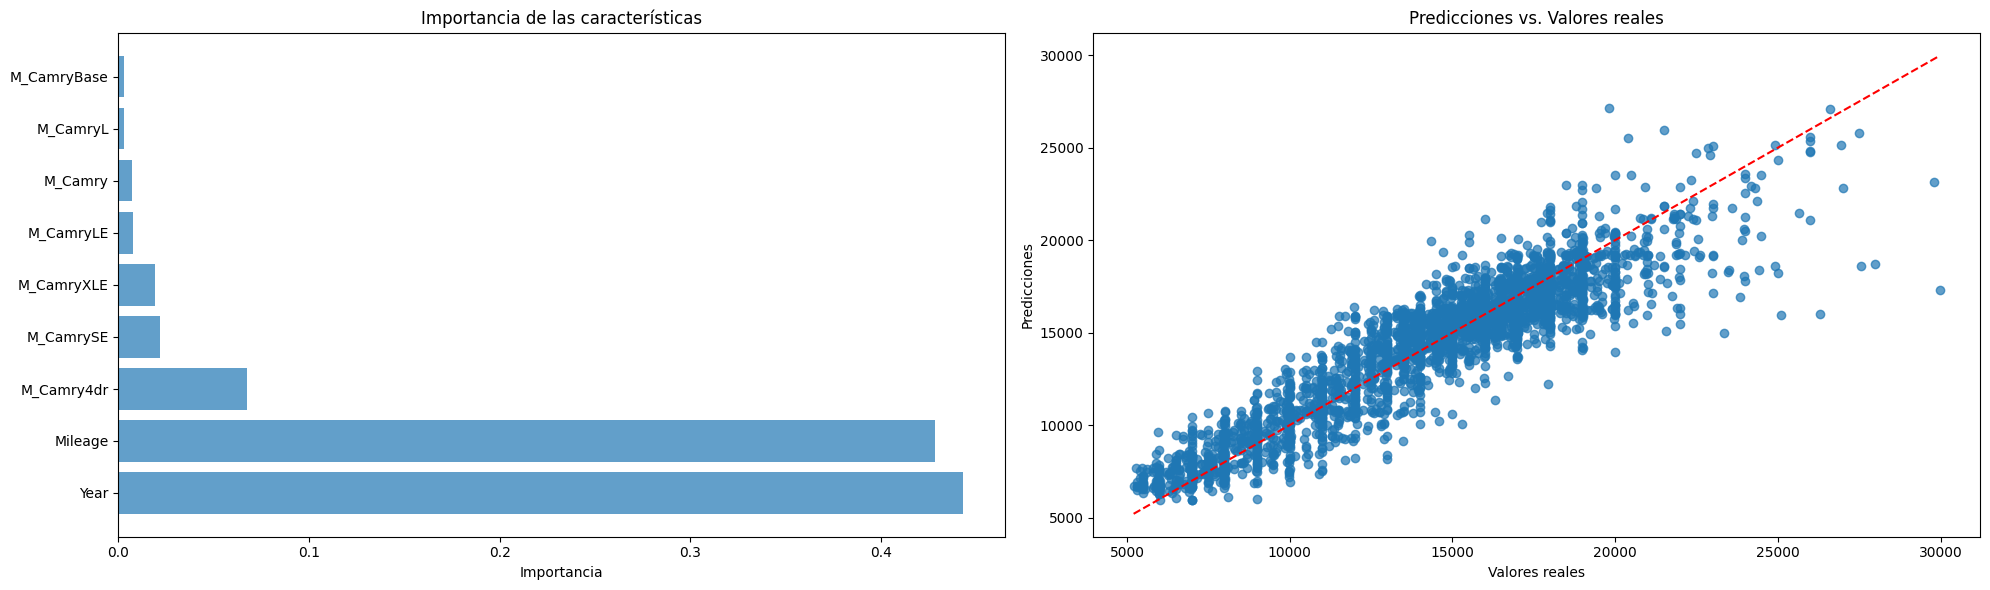

In [ ]:
def plot_combined(model, feature_names, X_train, y_train, X_test, y_test):
  feature_importance = model.feature_importances_
  sorted_idx = np.argsort(feature_importance)[::-1]

  predictions = model.predict(X_test)

  fig, axes = plt.subplots(1, 2, figsize=(20, 6))

  axes[0].barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', alpha=0.7)
  axes[0].set_yticks(range(len(sorted_idx)))
  axes[0].set_yticklabels([feature_names[i] for i in sorted_idx])
  axes[0].set_xlabel('Importancia')
  axes[0].set_title('Importancia de las características')

  axes[1].scatter(y_test, predictions, alpha=0.7)
  axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
  axes[1].set_xlabel('Valores reales')
  axes[1].set_ylabel('Predicciones')
  axes[1].set_title('Predicciones vs. Valores reales')

  plt.tight_layout()
  plt.show()

plot_combined(best_rf_regressor, X_train.columns, X_train, y_train, X_test, y_test)

**Análisis de Random Forest con calibración de parámetros**

Al realizar la calibración de los parámetros (max_depth, max_features y n_estimators) se observa que:
- A medida que aumenta el número de estimadores mejora el desempeño del modelo (debido a que promedia las predicciones de múltiples árboles y reduce la varianza del modelo), sin embargo, cuando se llega a n_estimators=350 se alcanza el máximo desempeño dentro del rango de valores propuesto. Adicionalmente, usualmente no se desea un número de estimadores muy grande, ya que va a generar mayor complejidad computacional.

- Respecto al parámetro max_depth, una mayor profundidad permite que los árboles se ajusten más a los datos de entrenamiento, lo que puede resultar en un mejor rendimiento en los datos de entrenamiento. Sin embargo, un árbol muy profundo puede sobreajustarse a los datos de entrenamiento y tener un peor rendimiento en los datos de prueba, lo que lleva a un modelo menos generalizable. En este caso, se observa que el valor más óptimo es 10, ya que los modelos asociados con esta profundidad tienen mejores rendimientos que con None o una profundidad de 20.

- El parámetro de max_features controla el número máximo de características que se consideran al dividir un nodo en un árbol. Elegir un número menor de características puede reducir la varianza del modelo y ayudar a prevenir el sobreajuste. Por otro lado, utilizar un mayor número de características puede aumentar la diversidad entre los árboles en el bosque y mejorar el rendimiento del modelo. En este caso, se obtuvo el mejor desempeño con log2 (3 características).

Por otra parte, se obtuvo, un MAE de 1146.76, un MSE de 2448532.16 y un RMSE de 1564.78, lo cual indica que al calibrar los parámetros se obtuvo un mejor desempeño en comparación con el modelo random forest no calibrado. Estos valores indican que, el modelo puede hacer predicciones más precisas en promedio en donde el error absoluto es de alrededor de 1147 dolares, con respecto al precio real.

Adicionalmente, en la gráfica de valores predichos vs valores reales, se observa que mejoró la predicción de precios altos de automoviles, lo que puede indicar que captura mejor las relaciones entre las variables predictivas y la variable objetivo en comparación con el modelo sin calibrar.

Finalmente, al igual que el modelo sin calibrar, este modelo le otorga más importancia a la variable `year`, luego a `Mileage`, y menos importancia a las variables de `M_Camry`. Sin embargo, la variable Mileage obtiene más importancia que en el anterior modelo, y también las variables M_Camry.




### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
XGB = xgb.XGBRegressor()
XGB.fit(X_train, y_train)

predictions = XGB.predict(X_test)

mse_xgboost = mean_squared_error(y_test, predictions)
mae_xgboost = mean_absolute_error(y_test, predictions)
r2_xgboost = r2_score(y_test, predictions)
rmse_xgboost = np.sqrt(mse_xgboost)
print("MSE:", mse_xgboost)
print("MAE:", mae_xgboost)
print("R²:", r2_xgboost)
print("RMSE:", rmse_xgboost)

MSE: 2576781.074646859
MAE: 1185.2272991506386
R²: 0.8315404997841507
RMSE: 1605.2355199928948


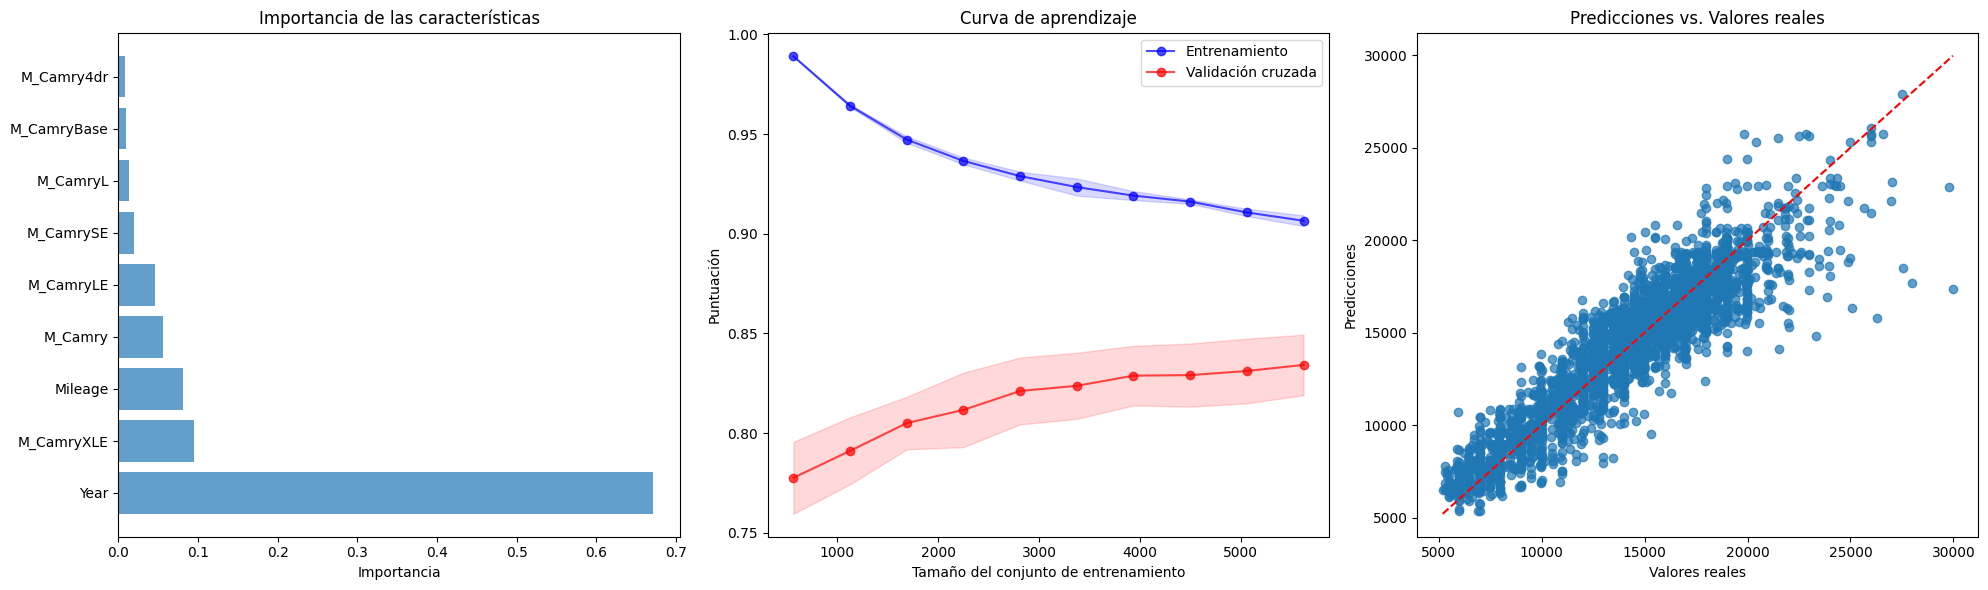

In [ ]:
def plot_combined(model, feature_names, X_train, y_train, X_test, y_test):

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]

    train_sizes, train_scores, test_scores = learning_curve(XGB, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    predictions = model.predict(X_test)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    axes[0].barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', alpha=0.7)
    axes[0].set_yticks(range(len(sorted_idx)))
    axes[0].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[0].set_xlabel('Importancia')
    axes[0].set_title('Importancia de las características')

    axes[1].plot(train_sizes, train_mean, marker='o', color='b', label='Entrenamiento', alpha=0.7)
    axes[1].fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='b')
    axes[1].plot(train_sizes, test_mean, marker='o', color='r', label='Validación cruzada', alpha=0.7)
    axes[1].fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='r')
    axes[1].set_xlabel('Tamaño del conjunto de entrenamiento')
    axes[1].set_ylabel('Puntuación')
    axes[1].set_title('Curva de aprendizaje')
    axes[1].legend(loc='best')

    axes[2].scatter(y_test, predictions, alpha=0.7)
    axes[2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    axes[2].set_xlabel('Valores reales')
    axes[2].set_ylabel('Predicciones')
    axes[2].set_title('Predicciones vs. Valores reales')

    plt.tight_layout()
    plt.show()

plot_combined(XGB, X_train.columns, X_train, y_train, X_test, y_test)

**Análisis XGBoost:**

- MSE: el MSE es aproximadamente 2576781.07, lo que quiere decir que los errores cuadráticos medios entre las predicciones del modelo y los valores reales son bastante grandes.

- MAE: el MAE es aproximadamente 1185.23, lo que significa que en promedio, el modelo se desvía de la verdad por alrededor de 1185.23 unidades.

- R²: el valor de R² es aproximadamente 0.832, lo que nos indica que el modelo explica aproximadamente el 83.2% de la variabilidad de los datos, lo cual es bastante bueno.

- RMSE: el RMSE es aproximadamente 1605.24, por lo tanto el promedio de las predicciones del modelo tienen un error de alrededor de 1605.24 unidades respecto a los valores reales.

Por lo anterior, aunque el modelo parece estar explicando una buena cantidad de la variabilidad en los datos (R² alto), todavía hay margen para mejorar, especialmente en términos de reducir los errores absolutos y cuadráticos. Por otro lado las características de menor a mayor importancia para el modelo son M_Camry4dr, M Camrylase, M CamryL, M CamrySE, M CamryLE, M Camry, Mileage, M CamryXLE y Year, teniendo esta ultima una importancia de alrededor del 0.68.

El modelo mejora significativamente a medida que se entrena con más datos, pero comienza a sobreajustarse después de cierto punto. Las predicciones del modelo son precisas y se ajustan bien a los valores reales.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  #Tasas de aprendizaje a probar
    'gamma': [0, 0.1, 0.2],  #Valores de gamma a probar
    'colsample_bytree': [0.6, 0.8, 1.0]  #Porcentaje de características a utilizar en cada árbol
}

xgb_reg = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error') #Con el metodo GridSearchCV encontrarermos los parametros
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores parámetros:", best_params)
best_model = grid_search.best_estimator_
predictions_xgb_reg = best_model.predict(X_test)
mse_best_xgboost = mean_squared_error(y_test, predictions_xgb_reg)
rmse_best_xgboost = sqrt(mse_best_xgboost)
print("Error cuadrático medio con los mejores parámetros:", mse_best_xgboost)
print("RMSE con los mejores parámetros:", rmse_best_xgboost)

Mejores parámetros: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1}
Error cuadrático medio con los mejores parámetros: 2405544.097653336
RMSE con los mejores parámetros: 1550.9816561305088


**Análisis parametros XGBoost:**

- learning_rate: Se seleccionaron tres valores comunes de tasas de aprendizaje: 0.01, 0.1 y 0.2. La tasa de aprendizaje controla la contribución de cada árbol al modelo y, por lo tanto, es crucial para la convergencia del modelo. Valores más bajos de tasa de aprendizaje suelen requerir más iteraciones (número de árboles) para converger, pero pueden conducir a modelos más robustos y generalizados.

- gamma: Se incluyeron tres valores típicos de gamma: 0, 0.1 y 0.2. El parámetro gamma especifica la reducción mínima en la función de pérdida requerida para realizar una división en un nodo del árbol. Un valor más alto de gamma conduce a una mayor regularización, lo que puede ayudar a prevenir el sobreajuste, pero también puede hacer que el modelo sea más conservador en términos de división de nodos.

- colsample_bytree: Se seleccionaron tres valores comunes para colsample_bytree: 0.6, 0.8 y 1.0. Este parámetro controla la fracción de características a considerar al construir cada árbol. Un valor menor puede ayudar a reducir el sobreajuste al introducir más variabilidad en los árboles, mientras que un valor de 1.0 considerará todas las características en cada árbol.


Por lo anterior:

- El valor de gamma encontrado durante la búsqueda en cuadrícula fue de 0. Esto significa que no se requiere una reducción mínima en la pérdida para hacer una división adicional en un nodo del árbol. En otras palabras, el modelo puede realizar divisiones adicionales en los nodos del árbol incluso si no hay una reducción significativa en la pérdida.

- colsample_bytree: 0.6, esto significa que en cada árbol, el modelo utiliza el 60% de las características seleccionadas aleatoriamente para dividir los nodos.
gamma: 0: Indica el valor de gamma que proporciona la reducción de pérdida mínima necesaria para hacer una división adicional en un nodo del árbol. Aquí, el valor de gamma es 0, lo que significa que no se requiere una reducción mínima en la pérdida para hacer una división.

- learning_rate: 0.1: Este es el parámetro que controla la tasa de aprendizaje del modelo. Un valor de 0.1 significa que se está utilizando una tasa de aprendizaje del 10%.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
# Datos de rendimiento de los modelos
model_names = ['Bagging', 'Random Forest', 'XGBoost']
mse_values = [mse_bagging, mse_rf, mse_xgboost]
rmse_values = [rmse_bagging, rmse_rf, rmse_xgboost]

# Normalizacion MSE y RMSE para una mejor visualización
mse_values_normalized = np.array(mse_values) / max(mse_values)
rmse_values_normalized = np.array(rmse_values) / max(rmse_values)

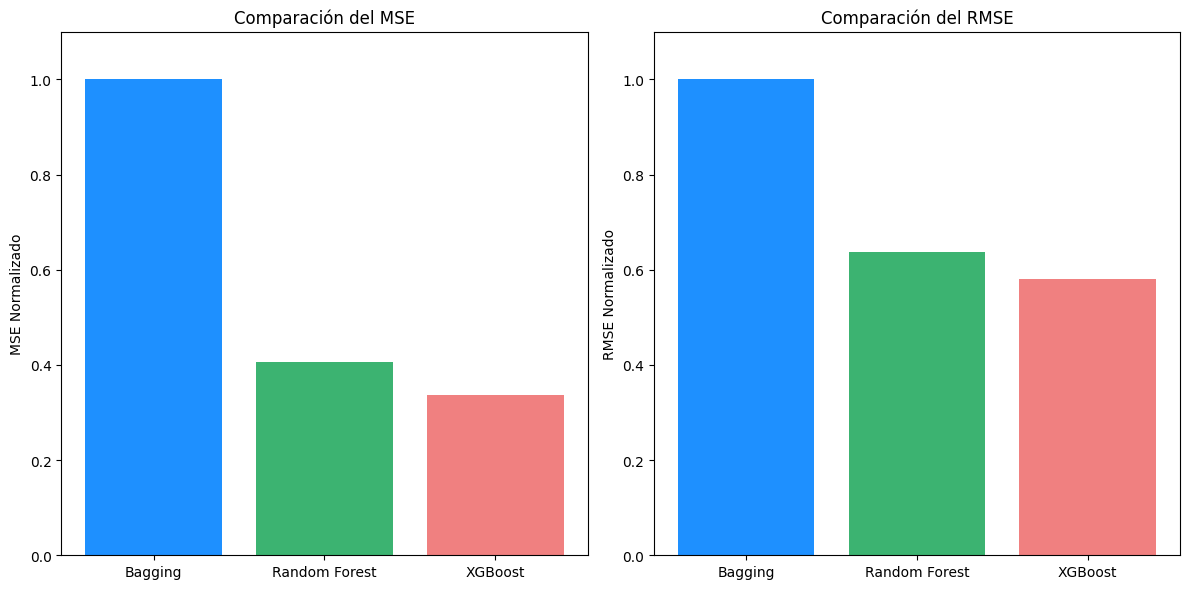

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para MSE
axes[0].bar(model_names, mse_values_normalized, color=['dodgerblue', 'mediumseagreen', 'lightcoral'])
axes[0].set_title('Comparación del MSE')
axes[0].set_ylabel('MSE Normalizado')
axes[0].set_ylim(0, 1.1)  # Ajustar según sea necesario

# Gráfico para RMSE
axes[1].bar(model_names, rmse_values_normalized, color=['dodgerblue', 'mediumseagreen', 'lightcoral'])
axes[1].set_title('Comparación del RMSE')
axes[1].set_ylabel('RMSE Normalizado')
axes[1].set_ylim(0, 1.1)  # Ajustar según sea necesario

plt.tight_layout()
plt.show()

# **Análisis de los Resultados**

En ambas métricas, MSE y RMSE, observamos una tendencia clara en la cual el modelo XGBoost supera a los otros dos modelos, seguido por el Random Forest y luego el Bagging. El modelo XGBoost tiene los valores más bajos de MSE y RMSE, lo que indica que tiene la mejor capacidad predictiva con los menores errores en las estimaciones de los precios de automóviles.

**Ventajas del Modelo XGBoost:**

* Menor Error: XGBoost tiene el menor MSE y RMSE, lo que indica una precisión más alta en las predicciones.
* Mejor Ajuste: El modelo puede capturar mejor la complejidad de los datos subyacentes.
* Generalización: El menor error sugiere que el modelo puede generalizar mejor a nuevos datos no vistos durante el entrenamiento.

**Desventajas del Modelo Bagging:**

* Mayor Error: El Bagging muestra el MSE y RMSE más altos, lo que indica un peor rendimiento en términos de error de predicción.

* Riesgo de Subajuste: Puede que no esté capturando suficientemente la complejidad de los datos, lo que sugiere un posible subajuste.

* Necesidad de Ajuste Fino: Puede requerir una configuración más cuidadosa de los parámetros y posiblemente una mejor selección o ingeniería de características para mejorar su rendimiento.

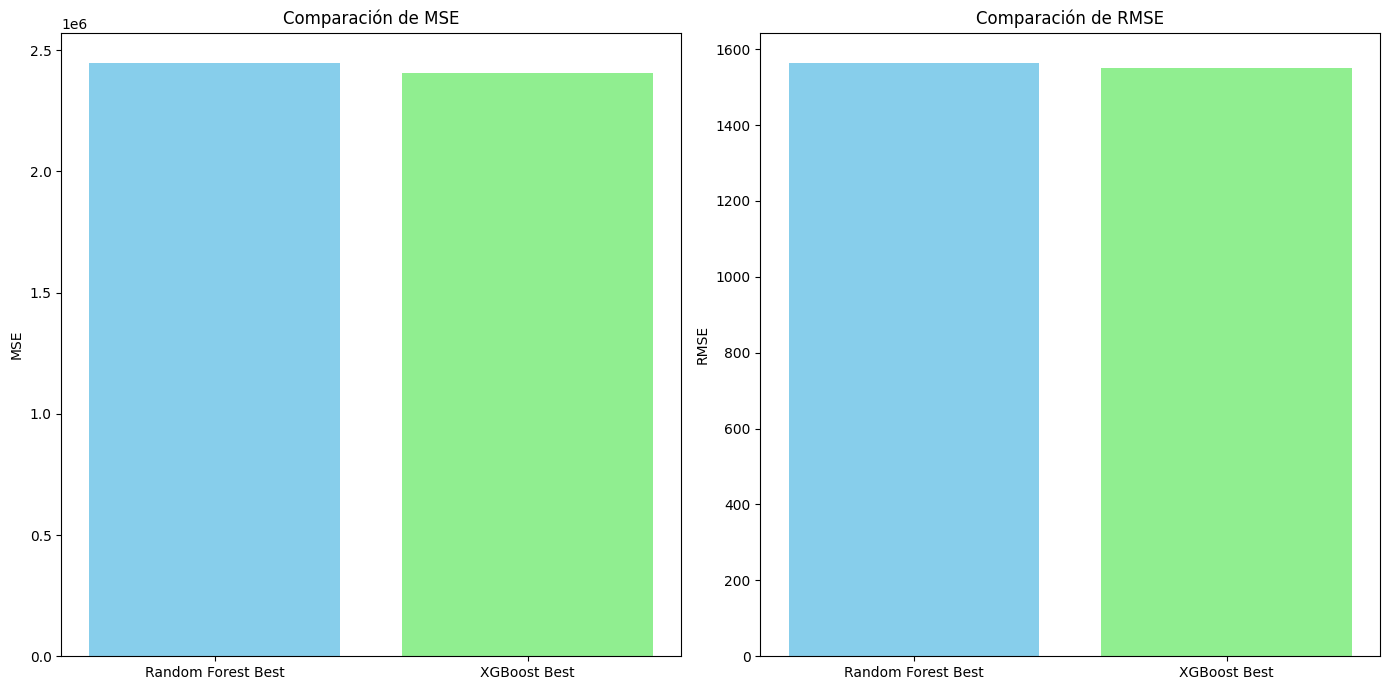

In [ ]:
# Datos de rendimiento de los modelos después de la calibración de hiperparámetros
model_names = ['Random Forest Best', 'XGBoost Best']
mse_values = [mse_rf_best, mse_best_xgboost]
rmse_values = [rmse_rf_best, rmse_best_xgboost]

# Gráficos de barras para MSE y RMSE
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Gráfico de comparación de MSE
ax[0].bar(model_names, mse_values, color=['skyblue', 'lightgreen'])
ax[0].set_title('Comparación de MSE')
ax[0].set_ylabel('MSE')

# Gráfico de comparación de RMSE
ax[1].bar(model_names, rmse_values, color=['skyblue', 'lightgreen'])
ax[1].set_title('Comparación de RMSE')
ax[1].set_ylabel('RMSE')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

# **Análisis de los Resultados**

Ambas gráficas muestran una comparación directa de los errores cuadráticos medios (MSE) y de las raíces del error cuadrático medio (RMSE) de los modelos Random Forest y XGBoost optimizados. El XGBoost muestra un MSE de aproximadamente 2,405,544 y un RMSE de aproximadamente 1,550.98, mientras que el Random Forest tiene un MSE de aproximadamente 2,448,532 y un RMSE de aproximadamente 1,564.78.

**Ventajas del modelo XGBoost:**

* Precisión: Con errores MSE y RMSE más bajos, XGBoost proporciona una mayor precisión en la predicción de precios de automóviles.
* Eficiencia: A menudo XGBoost es más eficiente con conjuntos de datos grandes gracias a su implementación optimizada y algoritmos de aproximación.
* Generalización: El menor error sugiere que XGBoost puede generalizar mejor cuando se enfrenta a datos no vistos, lo cual es crucial para la predicción en escenarios del mundo real.

**Desventajas del modelo Random Forest optimizado:**

* Rendimiento: Un MSE y RMSE ligeramente mayores pueden significar que el modelo Random Forest podría no estar capturando todas las complejidades o patrones en los datos tan eficientemente como XGBoost.
* Recursos y Tiempo: Random Forest puede ser más intensivo en recursos computacionales, especialmente con un gran número de árboles o cuando se busca el ajuste de hiperparámetros.